Wanting to apply our knowledge of TensorFlow and deep learning we decided to try out a simple RNN with an LSTM layer. First we had to clean the text and use one-hot encoding to give each word a unique value. Next we padded each array representation of tweets with 0s, so that every vector would be the same size. Lastly we created a model with an embedding layer with 40 embedding features and 100 LSTM blocks as shown below.


# 3.1 Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import re
import string

from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
newstopwords = ['rt', 'https', 'http', 'co',  'amp', 'vaccine', 'covid','vaccinate', 'vaccination', 'people', 'coronavirus','want', 'still', 'know', 'make', 'vaccinated', 'vaccines', 'u', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
stop_words.extend(newstopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/seanng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df = pd.read_csv('../Dataset/cleaned_dataset.csv', encoding = "utf-8")
df.drop("Unnamed: 0",axis=1,inplace=True)

In [5]:
import spacy
nlp = spacy.load('en_core_web_sm')

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = ''.join([c for c in text if c not in string.punctuation])
    tokens = re.split('\W+', text)
    text = ' '.join([word for word in tokens if word not in stop_words])
    text = nlp(text)
    text = ' '.join([word.lemma_ for word in text])
    return text

In [6]:
df['text'] = df['text'].apply(lambda x: clean_text(x))
df.head()

,text,is_misinfo
0,year old grandmother quarantine florida house ...,0
1,excited see day get back work thank celebrate ...,0
2,excited able close positive note get first dose,0
3,well happen daughter use grandchild try guilt ...,1
4,get baby fuck excited,0


# 3.2 One Hot

In [7]:
max_words = df['text'].apply(lambda x: len(x.split())).max()
max_words

51

In [8]:
voc_size = 5000
sentence_length = max_words

In [9]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
corpus = list(df['text'])

In [14]:
onehot_repr = [one_hot(words, voc_size) for words in corpus]
onehot_repr

[[1650,
  1600,
  3882,
  3088,
  205,
  1575,
  316,
  1650,
  4567,
  1063,
  1328,
  3047,
  3552,
  3349,
  722,
  3376,
  2842,
  1252,
  1127,
  1024],
 [4648,
  4410,
  1127,
  3047,
  2149,
  1598,
  241,
  1350,
  2093,
  2581,
  2581,
  4258,
  1598,
  801,
  2213,
  986,
  1127,
  1513,
  1771,
  922,
  3147],
 [4648, 1124, 316, 1525, 2752, 3047, 4129, 2842],
 [58,
  2842,
  2298,
  4778,
  4981,
  561,
  3162,
  1321,
  863,
  1274,
  3584,
  71,
  3478,
  717,
  3755,
  2316,
  839,
  1590,
  2640,
  1700],
 [3047, 155, 4720, 4648],
 [3176,
  3631,
  621,
  597,
  2135,
  4626,
  839,
  382,
  1031,
  3596,
  631,
  1322,
  4490,
  2107,
  629,
  3252,
  3875,
  2580,
  3047],
 [4648,
  3979,
  4183,
  4129,
  2842,
  1143,
  1650,
  211,
  1373,
  761,
  1984,
  1650,
  3741,
  4388,
  2919,
  893,
  721,
  4464,
  4067],
 [722, 619, 3047, 2438, 3349, 4648, 2207, 1293],
 [2859, 1449, 4567, 3047, 3562, 3414, 1063],
 [4648, 2985, 2379, 2985],
 [621,
  597,
  2135,
  4626,
 

In [15]:
embeded_docs = pad_sequences(onehot_repr, padding='pre', maxlen=sentence_length)
print(embeded_docs)

[[   0    0    0 ... 1252 1127 1024]
 [   0    0    0 ... 1771  922 3147]
 [   0    0    0 ... 3047 4129 2842]
 ...
 [   0    0    0 ... 2130 2999 1452]
 [   0    0    0 ... 1274 2987 2533]
 [   0    0    0 ... 1023 2843 4662]]


# 3.4 Splitting Data

In [17]:
X_train, X_test, y_train, y_test = train_test_split(embeded_docs, df['is_misinfo'], test_size=.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10301, 51), (2576, 51), (10301,), (2576,))

# 3.5 Building RNN w/ LSTM

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [19]:
embedding_vector_features=40

model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sentence_length))
model.add(Dropout(.3))
model.add(LSTM(100))
model.add(Dropout(.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 51, 40)            200000    
                                                                 
 dropout (Dropout)           (None, 51, 40)            0         
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


# 3.6 Training Model

In [20]:
ES = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)

In [21]:
history = model.fit(X_train,y_train, validation_split=.1, epochs=20, batch_size=32, callbacks=ES)

Epoch 1/20
290/290 [==============================] - 9s 26ms/step - loss: 0.2485 - accuracy: 0.8871 - val_loss: 0.1285 - val_accuracy: 0.9515
Epoch 2/20
290/290 [==============================] - 8s 26ms/step - loss: 0.0770 - accuracy: 0.9756 - val_loss: 0.1195 - val_accuracy: 0.9583
Epoch 3/20
290/290 [==============================] - 8s 26ms/step - loss: 0.0446 - accuracy: 0.9868 - val_loss: 0.1192 - val_accuracy: 0.9622
Epoch 4/20
290/290 [==============================] - 9s 31ms/step - loss: 0.0270 - accuracy: 0.9921 - val_loss: 0.1378 - val_accuracy: 0.9496
Epoch 5/20
290/290 [==============================] - 8s 27ms/step - loss: 0.0188 - accuracy: 0.9953 - val_loss: 0.2528 - val_accuracy: 0.9408
Epoch 6/20
290/290 [==============================] - 8s 27ms/step - loss: 0.0138 - accuracy: 0.9960 - val_loss: 0.2129 - val_accuracy: 0.9437
Epoch 7/20
290/290 [==============================] - 8s 28ms/step - loss: 0.0122 - accuracy: 0.9976 - val_loss: 0.1997 - val_accuracy: 0.9437

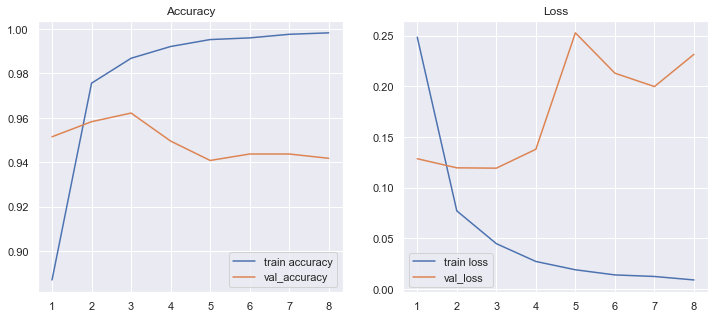

In [22]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, len(history.history['val_accuracy'])+1), 
         history.history['accuracy'], 
         label='train accuracy')
plt.plot(range(1, len(history.history['val_accuracy'])+1), 
         history.history['val_accuracy'], 
         label='val_accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(range(1, len(history.history['val_accuracy'])+1), 
         history.history['loss'], 
         label='train loss')
plt.plot(range(1, len(history.history['val_accuracy'])+1), 
         history.history['val_loss'], 
         label='val_loss')
plt.legend()
plt.title('Loss')
plt.show()

# 3.7 Evaluation

In [23]:
model.evaluate(X_test, y_test)

81/81 [==============================] - 1s 8ms/step - loss: 0.1038 - accuracy: 0.9647


[0.10378434509038925, 0.9646739363670349]

#### RNN's performance was less compared to the simpler models